In [1]:
import sys
sys.path.append('./libs')

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import colorcet as cc
import numpy as np
import pandas as pd
import h5py
from ipywidgets import interact, widgets
import pyvista as pv
import ats_vis as atsvis
import ats_xdmf as ats_xdmf

## Visualize exodus2 mesh

In [2]:
domain_mesh = atsvis.load_mesh_exodus('../data/synthetic_catchment.exo', z_scale=20)
pl = atsvis.plot_mesh(domain_mesh, show_scalar_bar=True, set_background=False, 
                      clim=[8, 11], show_toplayer=True, window_size=[960, 420])

Widget(value='<iframe src="http://localhost:59178/index.html?ui=P_0x16524d6a0_0&reconnect=auto" class="pyvista…

### Load ATS output files

In [3]:
# Load mesh polygons and data
data_directory = '../1-hydrology/results/'
domain = h5py.File(f'{data_directory}/ats_vis_data.h5', 'r')
domain_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_mesh.h5')
surface = h5py.File(f'{data_directory}/ats_vis_surface_data.h5', 'r')
surface_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_surface_mesh.h5')

In [4]:
# loading domain mesh file
vis_domain = ats_xdmf.VisFile(data_directory, time_unit='hr')
vis_domain.loadMesh()

# loading surface mesh file
vis_surface = ats_xdmf.VisFile(data_directory, domain='surface', time_unit='hr')
vis_surface.loadMesh()

# getting time and number of steps
time = vis_domain.times
cycles = vis_domain.cycles
num_steps = len(cycles)
num_surface_elements = np.shape(vis_surface.centroids)[0]
num_layers = int(np.shape(vis_domain.centroids)[0] / num_surface_elements)
print(f'Number of times: {num_steps}')
print(f'Number of surface elements: {num_surface_elements}')
print(f'Number of layers: {num_layers}')

Number of times: 49
Number of surface elements: 1521
Number of layers: 7


### Plot surface domain

In [5]:
vars_surface = ['pres_elev', 'ponded_depth', ['surface_subsurface_flux','cell_volume']]
interact(
    lambda step: atsvis.plot_surface(
        vars_surface, surface_polygons, vis_surface, step, time,
        vmin=[None, 0, -50],
        vmax=[None, 1, 50],
        cmap=[None, None, 'seismic'],
        units=['[m]', '[m]', '[molH2O/s]'],
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=48), Output()), _dom…

<function __main__.<lambda>(step)>

### Plot subsurface domain

In [6]:
vars_domain = ['pressure', 'saturation_liquid']
interact(
    lambda step, layer: atsvis.plot_domain(
        vars_domain, surface_polygons, vis_domain, num_surface_elements, step, time, layer,
        vmin=[None, 0.8],
        vmax=[None, 1],
        units=['[Pa]', '[%]'],
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1, continuous_update=False),
    layer=widgets.IntSlider(min=0, max=num_layers-1, step=1, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=48), IntSlider(value…

<function __main__.<lambda>(step, layer)>

### Plot Observations

#### Read the observations file

In [7]:
fname = f'{data_directory}/observations.csv'
num_lines = atsvis.get_skip_number(fname)

observations = pd.read_csv(fname,skiprows=num_lines,sep=",")
time_obs = observations['time [h]']
surface_flux_outlet = observations['surface-flux-outlet']
surface_flux_left_branch = -observations['surface-flux-left-branch']
surface_flux_right_branch = -observations['surface-flux-right-branch']

#### Plotting

In [8]:
# Read rainfall data from xml file
xml_file = '../1-hydrology/hydrology.xml'
rainfall = atsvis.get_rainfall_from_xml(xml_file, time_obs, sfactor=1000*3600)

# Surface fluxes
surface_flux_data = [surface_flux_outlet, surface_flux_left_branch, surface_flux_right_branch]
surface_flux_labels = ['Outlet', 'Left Branch', 'Right Branch']

<Axes: ylabel='Rainfall (mm/hr)'>

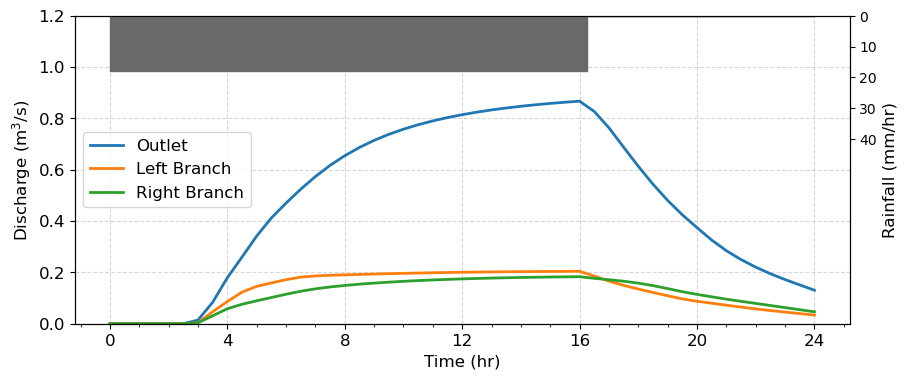

In [9]:
liq_mol_den = 55500  # molar density of water (mol/m^3)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Plot rainfall and water flux time series
atsvis.plot_field_timeseries( # fluxes
    time_obs, surface_flux_data, surface_flux_labels, sfactor=1./liq_mol_den,
    ylim=[0, 1.2], ylabel='Discharge (m$^3$/s)', ax=ax
)
atsvis.plot_sources(time_obs, rainfall, ylabel='Rainfall (mm/hr)', ax=ax) # rainfall